# Traffic Signs

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tempfile
import os
import tensorflow as tf
import pandas as pd
import io
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, Dense, Dropout, MaxPool1D, MaxPool2D, LSTM, Flatten, Reshape

In [4]:
#%tensorflow_version 2.x
#import tensorflow as tf
#%tensorflow_version 2.1.0
#tf.__version__

In [5]:
#!pip uninstall tensorflow
#!pip install tensorflow-gpu==2.1.0

In [6]:
from tensorflow import keras

In [7]:
#from google.colab import files
#uploaded = files.upload()

In [8]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)


# Import Data:

In [9]:
root_dir = "germantrafficsigns/"
df_signnames = pd.read_csv(root_dir+'signnames.csv')

In [10]:
df_signnames

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [11]:
df_signnames.SignName

0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vechiles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                                 Stop
15                                          No vechiles
16             Vechiles over 3.5 metric tons prohibited
17                                             N

We have 43 classes to predict

In [12]:
import pickle as pik
train_data_dic = pik.Unpickler(open(root_dir + 'train.p','rb')).load()
valid_data_dic = pik.Unpickler(open(root_dir + 'valid.p','rb')).load()
test_data_dic = pik.Unpickler(open(root_dir + 'test.p','rb')).load()

In [13]:
for x,y in train_data_dic.items(): 
  print("train data size :")
  print(x, y.shape)
for x,y in valid_data_dic.items(): 
  print(x, y.shape)
for x,y in test_data_dic.items(): 
  print(x, y.shape)

train data size :
coords (34799, 4)
train data size :
labels (34799,)
train data size :
features (34799, 32, 32, 3)
train data size :
sizes (34799, 2)
coords (4410, 4)
labels (4410,)
features (4410, 32, 32, 3)
sizes (4410, 2)
sizes (12630, 2)
coords (12630, 4)
features (12630, 32, 32, 3)
labels (12630,)


In [14]:
train_x = train_data_dic['features']
train_y = train_data_dic['labels']

valid_x = valid_data_dic['features']
valid_y = valid_data_dic['labels']

test_x = test_data_dic['features']
test_y = test_data_dic['labels']

In [15]:
train_y

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [16]:
df_signnames.iloc[0]['SignName']

'Speed limit (20km/h)'

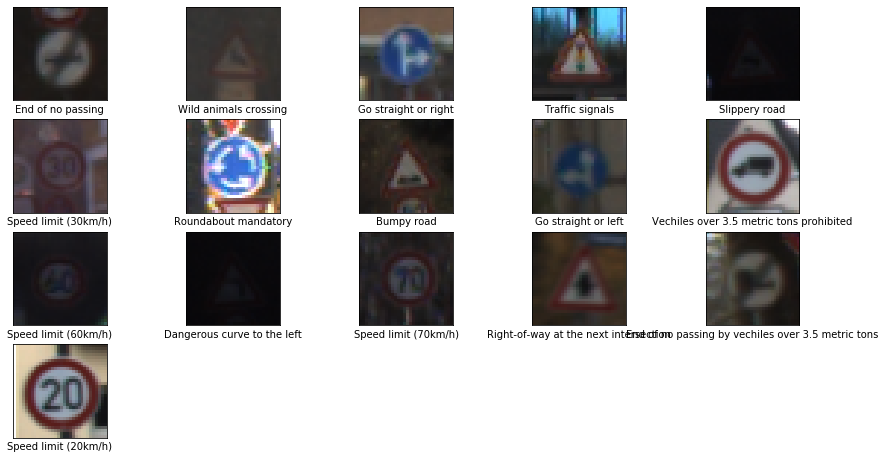

In [17]:
plt.figure(figsize=(15,10))
prev_label = -1
j=-1
for i in range(10000):
    if(prev_label != train_y[i]):
      j =j+1;
      plt.subplot(5,5,j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_x[i])
      plt.xlabel(df_signnames.iloc[train_y[i]]['SignName'])
      prev_label = train_y[i]
plt.show()

### GrayScale:

In [18]:
from skimage.color import rgb2gray
train_gray_x = rgb2gray(train_x)
valid_gray_x = rgb2gray(valid_x)
test_gray_x = rgb2gray(test_x)

In [19]:
train_gray_x.shape

(34799, 32, 32)

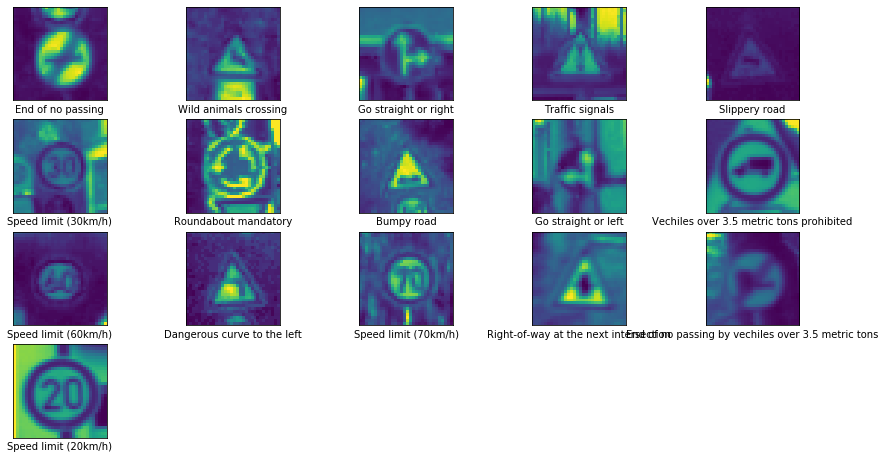

In [20]:
plt.figure(figsize=(15,10))
prev_label = -1
j=-1
for i in range(10000):
    if(prev_label != train_y[i]):
      j =j+1;
      plt.subplot(5,5,j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_gray_x[i])
      plt.xlabel(df_signnames.iloc[train_y[i]]['SignName'])
      prev_label = train_y[i]
plt.show()

### Target Distribution:

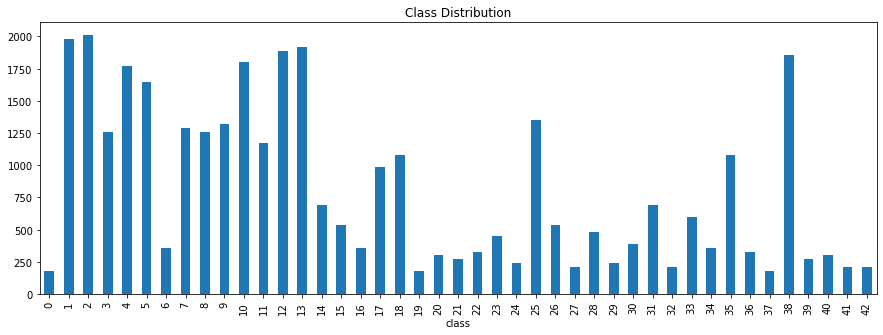

In [21]:
pd.Series(train_y).reset_index(name='class').groupby('class')['index'].count().plot(kind='bar', figsize=(15,5))
plt.title('Class Distribution');

In [22]:
num_classes = 43

# Models:

In [23]:
#scalling
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255
valid_x = valid_x.astype('float32')/255

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten, Input, MaxPooling2D, UpSampling2D

## CNN:

In [55]:
model = Sequential()
model.add(Conv2D(28, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax'))

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 28)        784       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        16192     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [57]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [58]:
model_acc = model.fit(train_x, train_y, epochs=10, validation_data=(valid_x, valid_y) )

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 123s 4ms/sample - loss: 1.2640 - accuracy: 0.6419 - val_loss: 0.3823 - val_accuracy: 0.9009
Epoch 2/10
34799/34799 [==============================] - 118s 3ms/sample - loss: 0.4070 - accuracy: 0.8702 - val_loss: 0.2383 - val_accuracy: 0.9333
Epoch 3/10
34799/34799 [==============================] - 121s 3ms/sample - loss: 0.2745 - accuracy: 0.9124 - val_loss: 0.1578 - val_accuracy: 0.9576
Epoch 4/10
34799/34799 [==============================] - 122s 3ms/sample - loss: 0.2093 - accuracy: 0.9309 - val_loss: 0.1386 - val_accuracy: 0.9594
Epoch 5/10
34799/34799 [==============================] - 130s 4ms/sample - loss: 0.1696 - accuracy: 0.9438 - val_loss: 0.1151 - val_accuracy: 0.9669
Epoch 6/10
34799/34799 [==============================] - 122s 4ms/sample - loss: 0.1455 - accuracy: 0.9526 - val_loss: 0.1488 - val_accuracy: 0.9567
Epoch 7/10
34799/34799 [===========================

In [72]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

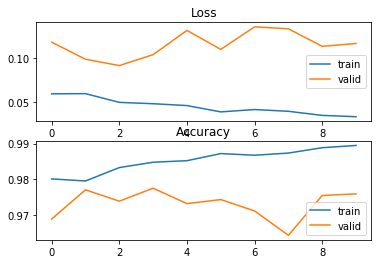

In [108]:
plt.subplot(211)
plt.title('Loss')
plt.plot(model_acc.history['loss'], label='train')
plt.plot(model_acc.history['val_loss'], label='valid')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(model_acc.history['accuracy'], label='train')
plt.plot(model_acc.history['val_accuracy'], label='valid')
plt.legend()

plt.show()

The model has been slightly overfitted.

In [61]:
pred_y = model.predict_classes(test_x)

result = model.evaluate(test_x, test_y, batch_size=64)
print(result)

12630/12630 [==============================] - 17s 1ms/sample - loss: 0.1455 - accuracy: 0.9680
[0.1455042591977714, 0.9680127]


### Augmentation:

In [62]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,5))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [63]:
type(train_x)

numpy.ndarray

In [117]:
from keras.preprocessing.image import ImageDataGenerator
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(#brightness_range=[1,2],
                               rotation_range=45,
                               width_shift_range=.15,
                               height_shift_range=.15,
                               zoom_range=[0.5,1.0])
#image_gen.fit(train_x)

In [118]:
# fits the model on batches with real-time data augmentation:
train_data_gen = image_gen.flow(train_x, train_y, batch_size=64)

In [119]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

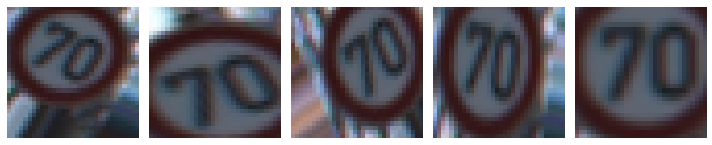

In [120]:
plotImages(augmented_images)

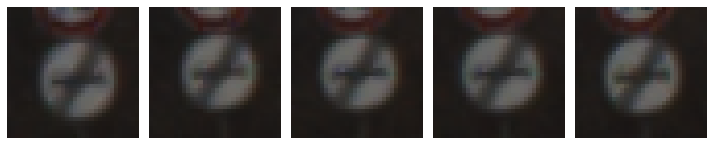

In [243]:
plotImages(train_x[:5])

In [67]:
model_new = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32 ,3)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])

In [69]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

In [75]:
model.load_weights(initial_weights)
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=len(train_x) // 64,
    epochs=10,
    validation_data=(valid_x,valid_y),
    validation_steps=len(valid_x) // 64
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 543 steps, validate on 4410 samples
Epoch 1/10
543/543 [==============================] - 117s 215ms/step - loss: 2.9115 - accuracy: 0.2024 - val_loss: 1.5206 - val_accuracy: 0.5921
Epoch 2/10
543/543 [==============================] - 114s 211ms/step - loss: 2.0163 - accuracy: 0.3880 - val_loss: 0.9587 - val_accuracy: 0.7592
Epoch 3/10
543/543 [==============================] - 117s 216ms/step - loss: 1.6237 - accuracy: 0.4891 - val_loss: 0.7700 - val_accuracy: 0.8097
Epoch 4/10
543/543 [==============================] - 116s 213ms/step - loss: 1.4326 - accuracy: 0.5413 - val_loss: 0.7720 - val_accuracy: 0.8208
Epoch 5/10
543/543 [==============================] - 117s 216ms/step - loss: 1.2998 - accuracy: 0.5822 - val_loss: 0.6645 - val_accuracy: 0.8196
Epoch 6/10
543/543 [==============================] - 115s 211ms/step - loss: 1.2050 - accuracy: 0.6055 - val_loss: 0.6514 

### Tuning:

In [30]:

model = Sequential()
model.add(Conv2D(28, (3,3), activation='relu', input_shape=(32,32, 3)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(28, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(num_classes, activation="softmax"))

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 28)        784       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        16192     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 28)        16156     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)        16192     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)         

In [32]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [34]:
model_acc = model.fit(train_x, train_y, epochs=10, validation_data=(valid_x, valid_y)) 

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 133s 4ms/sample - loss: 1.6109 - accuracy: 0.5275 - val_loss: 0.3748 - val_accuracy: 0.9043
Epoch 2/10
34799/34799 [==============================] - 130s 4ms/sample - loss: 0.3918 - accuracy: 0.8743 - val_loss: 0.2048 - val_accuracy: 0.9472
Epoch 3/10
34799/34799 [==============================] - 131s 4ms/sample - loss: 0.2194 - accuracy: 0.9316 - val_loss: 0.1458 - val_accuracy: 0.9683
Epoch 4/10
34799/34799 [==============================] - 133s 4ms/sample - loss: 0.1584 - accuracy: 0.9497 - val_loss: 0.1183 - val_accuracy: 0.9757
Epoch 5/10
34799/34799 [==============================] - 129s 4ms/sample - loss: 0.1247 - accuracy: 0.9608 - val_loss: 0.1364 - val_accuracy: 0.9762
Epoch 6/10
34799/34799 [==============================] - 127s 4ms/sample - loss: 0.1073 - accuracy: 0.9664 - val_loss: 0.0877 - val_accuracy: 0.9825
Epoch 7/10
34799/34799 [===========================

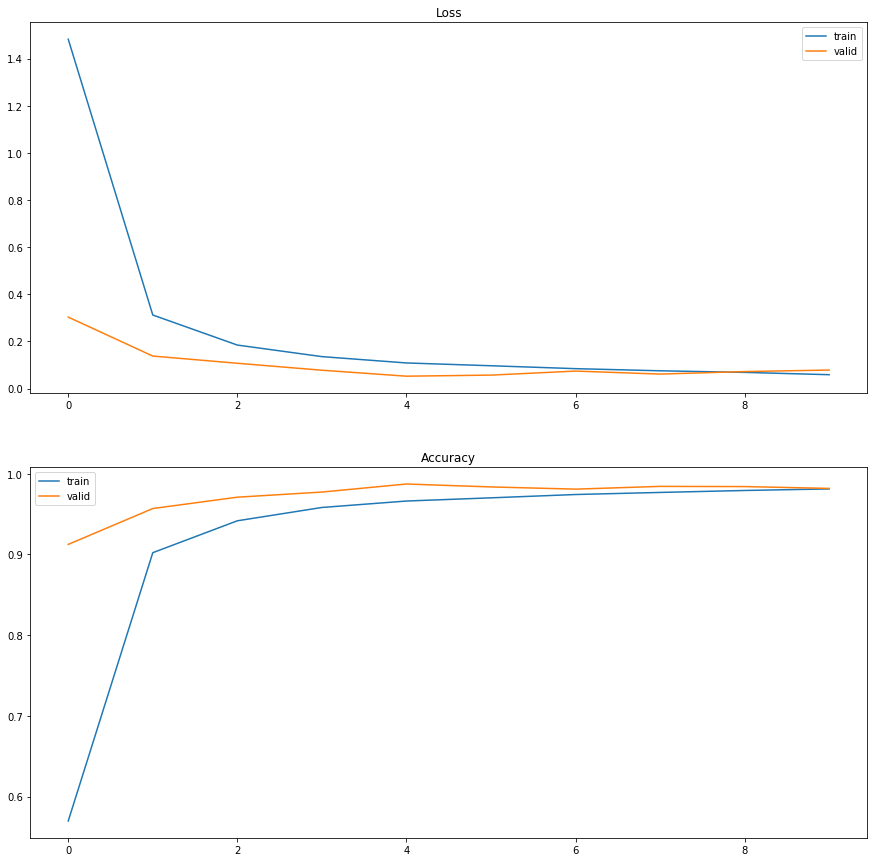

In [32]:
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.title('Loss')
plt.plot(model_acc.history['loss'], label='train')
plt.plot(model_acc.history['val_loss'], label='valid')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(model_acc.history['accuracy'], label='train')
plt.plot(model_acc.history['val_accuracy'], label='valid')
plt.legend()

plt.show()

In [33]:
pred_y = model.predict_classes(test_x)

result = model.evaluate(test_x, test_y, batch_size=64)
print(result)

12630/12630 [==============================] - 17s 1ms/sample - loss: 0.1650 - accuracy: 0.9640
[0.16504603597119463, 0.96397465]


### LSTM

#### Used gray scale images for this model

In [41]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Sequential
lstm_units = 200
BATCH_SIZE = 64


model = Sequential() 
# 3D tensor with shape (batch_size, timesteps, input_dim)
model.add(LSTM(units = lstm_units,input_shape = (32, 32), dropout=0.25, return_sequences=True)) 
model.add(LSTM(units = lstm_units, dropout=0.25))
model.add(Dense(124, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(num_classes, activation='softmax'))

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32, 200)           186400    
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_11 (Dense)             (None, 124)               24924     
_________________________________________________________________
dropout_8 (Dropout)          (None, 124)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 43)                5375      
Total params: 537,499
Trainable params: 537,499
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [45]:
%%time
hist = model.fit(train_gray_x, train_y, batch_size=64 ,epochs=15, validation_data=(valid_gray_x, valid_y))

Train on 34799 samples, validate on 4410 samples
Epoch 1/15
34799/34799 [==============================] - 118s 3ms/sample - loss: 2.7778 - accuracy: 0.2157 - val_loss: 2.0264 - val_accuracy: 0.4111
Epoch 2/15
34799/34799 [==============================] - 117s 3ms/sample - loss: 1.7779 - accuracy: 0.4542 - val_loss: 1.5883 - val_accuracy: 0.5268
Epoch 3/15
34799/34799 [==============================] - 118s 3ms/sample - loss: 1.3104 - accuracy: 0.5844 - val_loss: 1.3296 - val_accuracy: 0.6104
Epoch 4/15
34799/34799 [==============================] - 116s 3ms/sample - loss: 1.0687 - accuracy: 0.6598 - val_loss: 1.0200 - val_accuracy: 0.6855
Epoch 5/15
34799/34799 [==============================] - 118s 3ms/sample - loss: 0.9135 - accuracy: 0.7075 - val_loss: 0.9174 - val_accuracy: 0.7249
Epoch 6/15
34799/34799 [==============================] - 121s 3ms/sample - loss: 0.8226 - accuracy: 0.7362 - val_loss: 1.0074 - val_accuracy: 0.7159
Epoch 7/15
34799/34799 [===========================

In [46]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gray_x, test_y)

print('Test accuracy:', test_acc)

12630/12630 [==============================] - 15s 1ms/sample - loss: 0.9093 - accuracy: 0.7739
Test accuracy: 0.7738717


## Shallow Learning Models:

### LGBM

In [31]:
train_x_1d = train_x.reshape(train_x.shape[0],-1)
valid_x_1d = valid_x.reshape(valid_x.shape[0],-1)
test_x_1d = test_x.reshape(test_x.shape[0],-1)

In [30]:
import lightgbm as lgbm
import time
from sklearn.model_selection import GridSearchCV
hyper_params = dict(
        max_depth=[20,25], 
        min_data_in_leaf=[20, 100], 
        bagging_fraction=[.6,.8]
        
     )
clf = lgbm.LGBMClassifier()
grid = GridSearchCV(estimator=clf, cv=5, param_grid=hyper_params)
grid.fit(train_x_vec, train_y, early_stopping_rounds=10, eval_set=[[train_x_vec, train_y],[valid_x_vec,valid_y]], verbose=0)
print(grid.best_params_)

KeyboardInterrupt: 

In [32]:
import lightgbm as lgbm
import time

t = time.time()

model = lgbm.LGBMClassifier(n_estimators=200)
model.fit(train_x_vec, train_y, early_stopping_rounds=10, eval_set=[[train_x_vec, train_y],[valid_x_vec,valid_y]])

t = np.round(time.time()-t,2)
print(f'Execution time {t} seconds')

[1]	training's multi_logloss: 2.17301	valid_1's multi_logloss: 2.92896
Training until validation scores don't improve for 10 rounds
[2]	training's multi_logloss: 1.86475	valid_1's multi_logloss: 2.7106
[3]	training's multi_logloss: 1.65323	valid_1's multi_logloss: 2.5686
[4]	training's multi_logloss: 1.48207	valid_1's multi_logloss: 2.45312
[5]	training's multi_logloss: 1.34215	valid_1's multi_logloss: 2.36063
[6]	training's multi_logloss: 1.22187	valid_1's multi_logloss: 2.27513
[7]	training's multi_logloss: 1.1176	valid_1's multi_logloss: 2.20657
[8]	training's multi_logloss: 1.02645	valid_1's multi_logloss: 2.1405
[9]	training's multi_logloss: 0.944583	valid_1's multi_logloss: 2.07558
[10]	training's multi_logloss: 0.871278	valid_1's multi_logloss: 2.02231
[11]	training's multi_logloss: 0.804221	valid_1's multi_logloss: 1.97398
[12]	training's multi_logloss: 0.743178	valid_1's multi_logloss: 1.92948
[13]	training's multi_logloss: 0.688176	valid_1's multi_logloss: 1.88569
[14]	traini

In [55]:
print("Train Accuracy: ", model.score(train_x_vec,train_y))

1.0

In [56]:
model.score(valid_x_vec,valid_y)

0.7140589569160998

In [57]:
model.score(test_x_vec,test_y)

0.7367379255740301

## KNN:

In [33]:
from sklearn.neighbors import KNeighborsClassifier
import time
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x_1d,train_y)
#print(knn.score(test_x_flt,test_y))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [35]:
t = time.time()
print(knn.score(train_x_1d,train_y))

0.944394953877985


In [34]:
print(knn.score(valid_x_1d,valid_y))
print(knn.score(test_x_1d,test_y))

0.3247165532879819
0.3847189231987332


## Combined Model: